In [237]:
import pandas as pd
import numpy as np
import statistics as st
from scipy.stats import mode, skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [238]:
bnb_df = pd.read_csv("./BNB Historical Data.csv")
bnb_df

,Date,Price,Open,High,Low,Vol.,Change %
0,06/01/2024,601.80,593.80,608.19,593.20,161.02K,1.35%
1,05/31/2024,593.80,594.99,598.89,590.10,175.98K,-0.20%
2,05/30/2024,594.99,595.69,601.80,586.60,233.89K,-0.10%
3,05/29/2024,595.59,601.69,603.59,593.29,219.96K,-1.01%
4,05/28/2024,601.69,603.80,605.48,594.29,294.76K,-0.35%
...,...,...,...,...,...,...,...
1915,03/05/2019,13.65,11.40,13.74,11.40,8.34M,19.61%
1916,03/04/2019,11.41,11.45,11.51,10.88,2.74M,-0.29%
1917,03/03/2019,11.45,11.75,11.86,11.20,2.86M,-2.58%
1918,03/02/2019,11.75,11.35,11.80,10.83,3.89M,3.56%


### Pre-processing Data

In [239]:
print(bnb_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1920 non-null   object 
 1   Price     1920 non-null   float64
 2   Open      1920 non-null   float64
 3   High      1920 non-null   float64
 4   Low       1920 non-null   float64
 5   Vol.      1920 non-null   object 
 6   Change %  1920 non-null   object 
dtypes: float64(4), object(3)
memory usage: 105.1+ KB
None


* Định dạng lại cột `Date` để nó trở thành dạng `datetime`
* Xử lý và chuyển đổi kiểu dữ liệu của cột `Vol.` và `Change %` thành kiểu float

In [240]:
bnb_df['Date'] = pd.to_datetime(bnb_df['Date'])
bnb_df['Vol.'] = bnb_df['Vol.'].str.replace('M', 'e6').str.replace('K', 'e3').fillna('0')
bnb_df['Vol.'] = bnb_df['Vol.'].astype(float)
bnb_df['Change %'] = bnb_df['Change %'].str.replace('%', '').astype(float)
bnb_df.reset_index(drop=True)
bnb_df.set_index('Date', inplace=True)
bnb_df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-01,601.80,593.80,608.19,593.20,161020.0,1.35
2024-05-31,593.80,594.99,598.89,590.10,175980.0,-0.20
2024-05-30,594.99,595.69,601.80,586.60,233890.0,-0.10
2024-05-29,595.59,601.69,603.59,593.29,219960.0,-1.01
2024-05-28,601.69,603.80,605.48,594.29,294760.0,-0.35
...,...,...,...,...,...,...
2019-03-05,13.65,11.40,13.74,11.40,8340000.0,19.61
2019-03-04,11.41,11.45,11.51,10.88,2740000.0,-0.29
2019-03-03,11.45,11.75,11.86,11.20,2860000.0,-2.58


In [241]:
missing_values = bnb_df.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


In [242]:
print(bnb_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1920 entries, 2024-06-01 to 2019-03-01
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     1920 non-null   float64
 1   Open      1920 non-null   float64
 2   High      1920 non-null   float64
 3   Low       1920 non-null   float64
 4   Vol.      1920 non-null   float64
 5   Change %  1920 non-null   float64
dtypes: float64(6)
memory usage: 105.0 KB
None


In [243]:
sol_description = bnb_df.describe()
sol_description

,Price,Open,High,Low,Vol.,Change %
count,1920.000000,1920.000000,1920.000000,1920.000000,1.920000e+03,1920.000000
mean,229.552547,229.245161,235.806146,222.272714,4.316261e+06,0.329344
std,184.430107,184.300217,189.692063,178.382323,2.135747e+07,4.891566
min,9.250000,9.250000,10.410000,6.500000,8.993000e+04,-44.080000
25%,27.030000,27.027500,27.807500,26.082500,5.633800e+05,-1.610000
50%,247.550000,247.055000,254.285000,242.050000,1.600000e+06,0.130000
75%,332.110000,331.345000,339.792500,322.325000,3.772500e+06,2.160000
max,676.560000,676.250000,690.870000,634.810000,3.995400e+08,69.990000


In [244]:
# Descriptive statistics for Price
print('More Price Statistics:')

print('Mode:', bnb_df['Price'].mode().values[0])
print('Standard Deviation:', bnb_df['Price'].std())
print('Variance:', bnb_df['Price'].var())
print('Kurtosis:', bnb_df['Price'].kurt())
print('Skewness:', bnb_df['Price'].skew())

More Price Statistics:
Mode: 23.01
Standard Deviation: 184.43010721388004
Variance: 34014.46444692328
Kurtosis: -0.8960616714167435
Skewness: 0.33018718587724444


##### Price by Date Plot

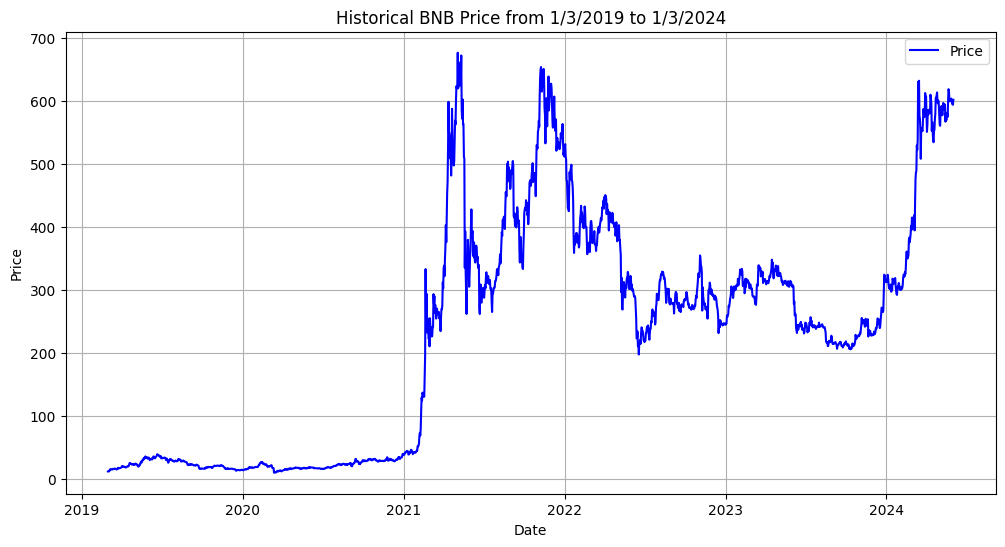

In [245]:
plt.figure(figsize=(12, 6))
plt.plot(bnb_df['Price'], label='Price', color='b')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Historical BNB Price from 1/3/2019 to 1/3/2024')
plt.legend()
plt.grid(True)
plt.show()


##### Boxplot for Price

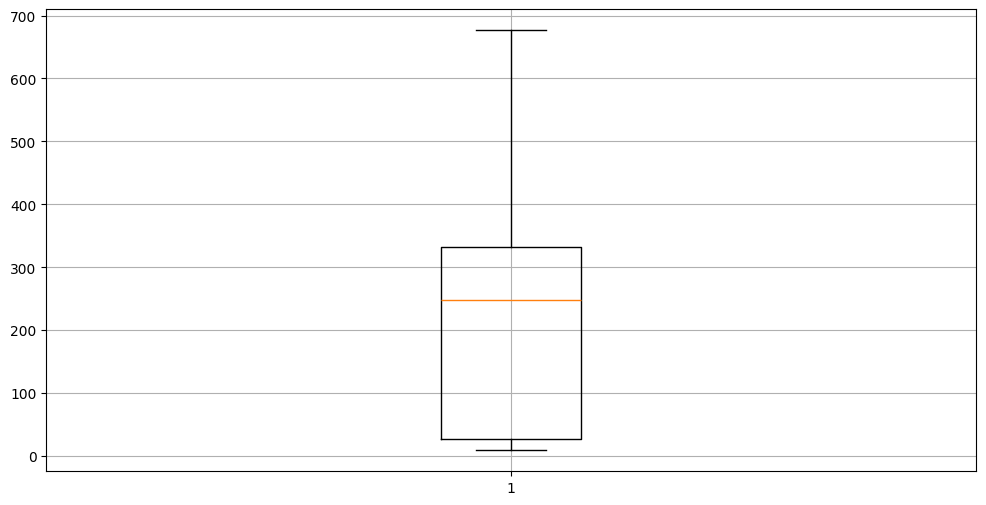

In [246]:
plt.figure(figsize=(12, 6))
plt.boxplot(bnb_df['Price'])
plt.grid()
plt.show()

### Parameter

In [247]:
window_size = 10
feature_dim = 5
test_size=0.2

# model params
lstm_neurons = 20
rnn_neurons = 20
epochs = 100
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

### Split data

In [248]:
# Define the target variable
target = 'Price'

In [249]:
train_set = bnb_df[(bnb_df.index >= '2019-03-01') & (bnb_df.index <= '2024-03-01')]
test_set = bnb_df[(bnb_df.index > '2024-03-01') & (bnb_df.index <= '2024-06-01')]

print("Training data shape: ", train_set.shape)
print("Testing data shape: ", test_set.shape)

Training data shape:  (1828, 6)
Testing data shape:  (92, 6)


In [250]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_set_scaled = scaler.fit_transform(train_set)
test_set_scaled = scaler.transform(test_set)

train_set_scaled = pd.DataFrame(train_set_scaled, index=train_set.index, columns=train_set.columns)
test_set_scaled = pd.DataFrame(test_set_scaled, index=test_set.index, columns=test_set.columns)

In [251]:
X_train = train_set_scaled.drop(columns=target)
y_train = train_set_scaled[target]
X_test = test_set_scaled.drop(columns=target)
y_test = test_set_scaled[target]

In [252]:
print('X_train shape: ',X_train.shape)
print('y_train shape: ',y_train.shape)
print('X_test shape: ',X_test.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (1828, 5)
y_train shape:  (1828,)
X_test shape:  (92, 5)
y_test shape:  (92,)


### Model Training

##### Linear Regression

In [253]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

###### Evaluate Linear Regression

In [254]:
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"MAPE: {mape}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAPE: 0.008929674663506349
MAE: 0.007428234647804426
RMSE: 0.01094091904634508


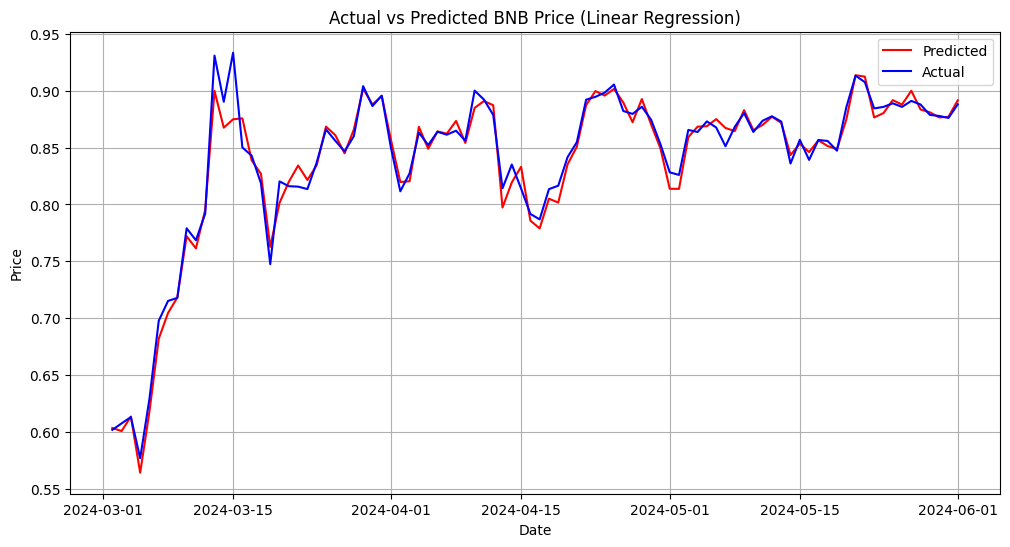

In [255]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_pred.reshape(-1)), color='r', label='Predicted')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_test), color='b', label='Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted BNB Price (Linear Regression)')
plt.legend()
plt.grid(True)
plt.show()